In [1]:
import os
import glob
import re

import pandas as pd
import numpy as np
from datetime import datetime
from collections import defaultdict
from scipy.stats import pearsonr

## Data Cleaning

- csv_parse: Merges all csv files in a specified folder into a single dataframe.
- clean: Filters dataframe to only include specified columns, and drops missing values in important columns.
- filter_columns: Restricts chosen columns to only contain specified values, i.e. activity codes, ranges of duration and enjoyment score.
- clean_date: Converts string to datetime object, allowing for different formats.
- clean_day: Rewrites 'DayOfWeek' column to match dates in 'StartDate' column to avoid possible errors in mismatching day names.
- clean_time: Converts string to datetime object then back to string in '%H:%M' format, allowing for different time formats.
- clean_data: function that takes input folder and performs all above functions.

In [2]:
path = os.getcwd() #Creating path

def csv_parse(folder): #Merging .csv files in specified folder
    data = path + f'/{folder}/'
    data_files = glob.glob(data + '/*.csv')
    lst = []

    for filename in data_files:
        try:
            df = pd.read_csv(filename, index_col=None)
            df['ID'] = filename[-12:-4] #Creating unique ID for each file
            lst.append(df)
        except ValueError:
            pass #If incompatible csv file provided, pass

    df = pd.concat(lst, axis=0, ignore_index=True)
    df.dropna(axis = 0, how = 'all', inplace = True) #Dropping rows that contain missing values for all labels
    return df

def clean(df):
    col_list = ['ID', 'PrimaryActivityCode','SecondaryActivityCode', 'DescriptiveLabel',
            'StartDate', 'DayOfWeek', 'StartTime', 'EndTime', 'DurationMins',
            'EnjoymentScore'] #Columns required in completed data
    df = df[col_list]
    df = df.astype({'ID': 'str', 
                    'PrimaryActivityCode': 'str', 
                    'SecondaryActivityCode': 'str', 
                    'DescriptiveLabel': 'str',
                    'DayOfWeek': 'str'
                    }) #Ensuring such columns are in string format
    df['DurationMins'] = pd.to_numeric(df['DurationMins'], errors='coerce') #Converting column to float or 'NaN'
    df['EnjoymentScore'] = pd.to_numeric(df['EnjoymentScore'], errors='coerce')
    
    col_list.remove('SecondaryActivityCode')
    col_list.remove('DescriptiveLabel')
    
    for col in col_list:
        df = df.drop(df[df[col].isnull()].index.tolist())
    
    for col in list(df.columns):
        if df[col].dtype == 'O':
            df[col] = df[col].str.strip() #Removing whitespace in specified columns
    
    return df

def filter_columns(df):
    activity_codes = ['ED145', 'L418', 'O733', 'T695', 'EL642', 'S801', 'CW982', 'UD415',
                     'H179', 'X893', 'R523', 'PW101', 'nan'] #Restricting values to these activity codes
    df = df[df['PrimaryActivityCode'].isin(activity_codes[:-1])]
    df = df[df['SecondaryActivityCode'].isin(activity_codes)]
    df = df[df['DurationMins'] > 0] #Ensuring that duration is positive and less than 18 hours for a single activity
    df = df[df['DurationMins'] < 18*60]
    df['DescriptiveLabel'] = df['DescriptiveLabel'].apply(lambda x: 'nan' if x == '' else x) #Converting empty string to 'nan' 
    df = df[df['EnjoymentScore'].isin(list(range(-2,3,1)))] 
    return df

def clean_date(text):
    for fmt in ('%Y-%m-%d', '%Y.%m.%d', '%Y/%m/%d', 
                '%d-%m-%Y', '%d.%m.%Y', '%d/%m/%Y', 
                '%d-%m-%y', '%d.%m.%y', '%d/%m/%y'):
        try:
            return datetime.strptime(text, fmt)
        except ValueError:
            pass
def clean_day(date_time):
    return date_time.strftime("%A")

def clean_time(text):
    for fmt in ('%H:%M', '%H:%M:%S', '%I:%M:%S %p', '%I:%M %p'):
        try:
            return datetime.strptime(text, fmt).strftime("%H:%M")
        except ValueError:
            pass

In [3]:
def clean_data(folder_name):
    df = clean(csv_parse(folder_name))
    try:
        df = filter_columns(df)

        df['StartDate'] = df['StartDate'].apply(clean_date)
        df = df[df['StartDate'].map(type) == pd.Timestamp]
        df['DayOfWeek'] = df['StartDate'].apply(clean_day)

        df['StartTime'] = df['StartTime'].apply(lambda x: '00:00' if x == '24:00' else x)
        df['StartTime'] = df['StartTime'].apply(clean_time)

        df['EndTime'] = df['EndTime'].apply(lambda x: '00:00' if x == '24:00' else x)
        df['EndTime'] = df['EndTime'].apply(clean_time)

        df = df.replace('nan', np.nan)
        return df
    except KeyError as err:
        print(err)

## Viewing the Dataframes
- Visualising both dataframes seperately to determine they look correct.

In [4]:
clean_data('data')

,ID,PrimaryActivityCode,SecondaryActivityCode,DescriptiveLabel,StartDate,DayOfWeek,StartTime,EndTime,DurationMins,EnjoymentScore
2,21558723,H179,O733,NaN,2021-03-02,Tuesday,07:45,08:30,45.0,0.0
7,21558723,EL642,UD415,Online lecture,2021-03-02,Tuesday,12:15,13:15,60.0,1.0
8,21558723,EL642,UD415,Online lecture,2021-03-02,Tuesday,13:15,14:15,60.0,1.0
39,21558723,L418,UD415,Watching Television,2021-03-04,Thursday,14:30,15:00,30.0,2.0
40,21558723,EL642,UD415,Online lecture,2021-03-04,Thursday,15:15,17:15,120.0,0.0
...,...,...,...,...,...,...,...,...,...,...
3117,21558712,L418,UD415,playing switch game,2020-03-09,Monday,20:00,21:15,75.0,1.0
3118,21558712,L418,UD415,using moblie,2020-03-09,Monday,21:15,22:15,60.0,1.0
3119,21558712,O733,NaN,preparing for sleep,2020-03-09,Monday,22:15,22:45,30.0,0.0
3120,21558712,L418,UD415,watching videos,2020-03-09,Monday,22:45,23:45,60.0,1.0


In [5]:
clean_data('data 2')

/Users/emtiazsamad/opt/anaconda3/envs/datascience/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (0,2,3,5,6,7,16) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,ID,PrimaryActivityCode,SecondaryActivityCode,DescriptiveLabel,StartDate,DayOfWeek,StartTime,EndTime,DurationMins,EnjoymentScore
0,22056718,ED145,L418,Eating/Drinking,2022-02-17,Thursday,08:30,08:45,15.0,1.0
1,22056718,T695,NaN,Travelling,2022-02-17,Thursday,09:00,09:30,30.0,-1.0
2,22056718,EL642,NaN,Education/Lectures,2022-02-17,Thursday,09:30,11:45,135.0,0.0
3,22056718,EL642,NaN,Education/Lectures,2022-02-17,Thursday,12:00,13:00,60.0,1.0
4,22056718,ED145,L418,Eating/Drinking,2022-02-17,Thursday,13:15,14:00,45.0,2.0
...,...,...,...,...,...,...,...,...,...,...
1052873,22056729,L418,NaN,Met family - coffee,2022-02-19,Saturday,14:30,17:00,150.0,2.0
1052874,22056729,L418,UD415,Watching TV,2022-02-19,Saturday,17:00,19:30,150.0,2.0
1052875,22056729,ED145,L418,Out for dinner,2022-02-19,Saturday,19:30,21:00,90.0,2.0
1052876,22056729,L418,UD415,Playing a game,2022-02-19,Saturday,21:00,23:00,120.0,2.0


## Merging Data
- Merging both sets of data into a single dataframe

In [6]:
data = clean_data('data')
data2 = clean_data('data 2')
df = pd.concat([data, data2], axis=0)
df

/Users/emtiazsamad/opt/anaconda3/envs/datascience/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (0,2,3,5,6,7,16) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,ID,PrimaryActivityCode,SecondaryActivityCode,DescriptiveLabel,StartDate,DayOfWeek,StartTime,EndTime,DurationMins,EnjoymentScore
2,21558723,H179,O733,NaN,2021-03-02,Tuesday,07:45,08:30,45.0,0.0
7,21558723,EL642,UD415,Online lecture,2021-03-02,Tuesday,12:15,13:15,60.0,1.0
8,21558723,EL642,UD415,Online lecture,2021-03-02,Tuesday,13:15,14:15,60.0,1.0
39,21558723,L418,UD415,Watching Television,2021-03-04,Thursday,14:30,15:00,30.0,2.0
40,21558723,EL642,UD415,Online lecture,2021-03-04,Thursday,15:15,17:15,120.0,0.0
...,...,...,...,...,...,...,...,...,...,...
1052873,22056729,L418,NaN,Met family - coffee,2022-02-19,Saturday,14:30,17:00,150.0,2.0
1052874,22056729,L418,UD415,Watching TV,2022-02-19,Saturday,17:00,19:30,150.0,2.0
1052875,22056729,ED145,L418,Out for dinner,2022-02-19,Saturday,19:30,21:00,90.0,2.0
1052876,22056729,L418,UD415,Playing a game,2022-02-19,Saturday,21:00,23:00,120.0,2.0


## Visualising the Data
- Creating plots to guage if the data looks as expected

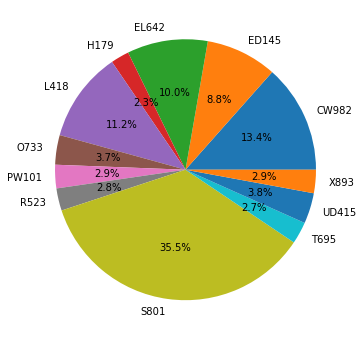

In [7]:
import matplotlib.pyplot as plt
df.groupby('PrimaryActivityCode').DurationMins.sum().plot.pie(label="", autopct='%1.1f%%', figsize=(6,6))
plt.show() #The data looks as expected for the most part, e.g. sleep accounts for approximately a third of the duration

This plot does not accurately represent screen time since it has been mainly recorded as a secondary activity, so all primary activities will temporarily be replaced with 'UD415' where it is recorded as a secondary activity.

## Hypothesis: Does Screentime Affect Sleep?
- We will explore the dataset to look for relationships between the duration of time spent using devices and time spent sleeping.
- We should expect to see a negative correlation with screen time and sleep, since research shows that blue light emitted from screens can negatively impact sleep.
- For the purposes of the following tests, we will use the altered dataframe 'df2' which replaces primary activities with secondary activity device usage.
- Null Hypothesis: There is not a significant relationship between sleep duration and screen time.
- Alternate Hypothesis: There is a significant relationship between sleep duration and screen time.

I will also be looking at answering the following questions:
- How much of the day is spent using devices?
- What is the relationship between evening screen time and sleep duration?
- What is the relationship between off-screen time and sleep duration?

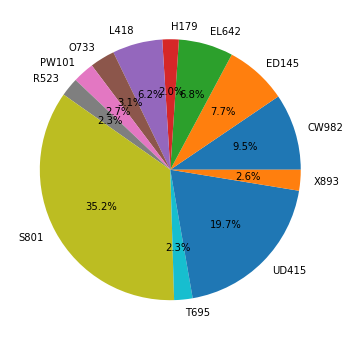

In [8]:
df2 = df.copy()
df2.loc[df2['SecondaryActivityCode'] == 'UD415', 'PrimaryActivityCode'] = 'UD415'
df2.groupby('PrimaryActivityCode').DurationMins.sum().plot.pie(label="", autopct='%1.1f%%', figsize=(6,6))
plt.show()

- This gives us a better indication of the actual daily screentime in proportion to other recorded activities.
- Screentime accounts for roughly 20% of daily activities and sleep accounts for approximately 35%.

## Data Preparation
- Slicing the dataframe to remove unnecessary data
- Organising data; grouping by ID and date to create different 'observations' for plots

In [9]:
df2 = df2[(df2['PrimaryActivityCode'] == 'UD415')|(df2['PrimaryActivityCode'] == 'S801')]
df2 = df2[['ID', 'PrimaryActivityCode', 'StartDate', 'DurationMins']]

df2 = df2[df2.groupby(['ID'])['PrimaryActivityCode'].transform('nunique') > 1]
df2 = df2.groupby(['ID', 'PrimaryActivityCode', 'StartDate'])['DurationMins'].sum().reset_index()

d = defaultdict(float)

for row in range(len(df2)):
    d[df2['ID'][row], df2['StartDate'][row].strftime("%Y-%m-%d")] += 1

df2['count_val'] = 0
for id, date in d.keys():
    index = list(df2[(df2['ID'] == id) & (df2['StartDate'] == date)].index)
    df2['count_val'].loc[index] = d[id, date]

df2 = df2[df2['count_val'] != 1]
df2 = df2[df2['DurationMins'] < 900] #filtering out erroneous durations for sleep and device usage

/Users/emtiazsamad/opt/anaconda3/envs/datascience/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [10]:
s_df = df2[df2['PrimaryActivityCode'] == 'S801'][['ID', 'StartDate', 'DurationMins']]
e_df = df2[df2['PrimaryActivityCode'] == 'UD415'][['ID', 'StartDate', 'DurationMins']]

df3 = pd.merge(s_df, e_df, how='inner', on=['ID', 'StartDate'])
df3 = df3.rename(columns={'DurationMins_x': 'SleepDuration', 'DurationMins_y': 'ScreenTime'})
df3 = df3[df3['SleepDuration'] + df3['ScreenTime'] < 1200] #filter out observations where both activities account for more than 20 hours of the day
df3.loc[:, 'SleepDuration':'ScreenTime'] = df3.loc[:, 'SleepDuration':'ScreenTime']/60 #Converting from minutes to hours

## Plotting Data and Determining Significance
- Calculating Pearson's correlation coefficient and p-value to determine if there is a significant relationship between sleep duration and screen time from the provided data.
- Plotting a simple scatter plot and line of best fit to visualise correlation of data.

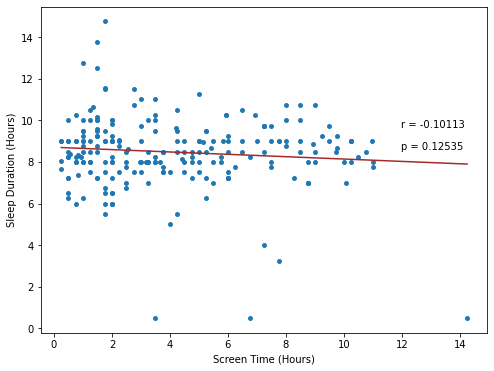

In [11]:
r0, p0 = pearsonr(df3['SleepDuration'], df3['ScreenTime'])

plt.figure(figsize=(8,6))
plt.scatter(df3['ScreenTime'], df3['SleepDuration'], s=15)
plt.plot(np.unique(df3['ScreenTime']), 
         np.poly1d(np.polyfit(df3['ScreenTime'], df3['SleepDuration'], 1))(np.unique(df3['ScreenTime'])),
        color='brown')
plt.xlabel('Screen Time (Hours)')
plt.ylabel('Sleep Duration (Hours)')
plt.figtext(.75, .6, f'r = {r0.round(5)}')
plt.figtext(.75, .55, f'p = {p0.round(5)}')
plt.show()

There does not seem to be a significant correlation between screen time and sleep. However, we can further improve our hypothesis to consider the impact of evening screen time on sleep duration, since studies show that using devices before going to sleep can result in poor sleep.

## Evening Screen Time vs Sleep Duration
- Comparing sleep duration with screen time recorded after 19:00, and off screen time in the same period before sleep.

In [12]:
df4 = df.loc[:, ['ID', 
                 'PrimaryActivityCode', 
                 'SecondaryActivityCode', 
                 'StartDate', 
                 'StartTime', 
                 'DurationMins']]

df4.loc[df4['SecondaryActivityCode'] == 'UD415', 'PrimaryActivityCode'] = 'UD415'
df4.loc[(df4['PrimaryActivityCode'] != 'S801') & (df4['PrimaryActivityCode'] != 'UD415'), 
        'PrimaryActivityCode'] = 'Other'
df4 = df4.drop('SecondaryActivityCode', axis=1)

df_pie = df4.copy()

df4 = df4[(df4['StartTime'] >= '20:00') | (df4['PrimaryActivityCode'] == 'S801')]

df4 = df4[df4.groupby(['ID'])['PrimaryActivityCode'].transform('nunique') > 1]
df4 = df4.groupby(['ID', 'PrimaryActivityCode', 'StartDate'])['DurationMins'].sum().reset_index()

d2 = defaultdict(float)

for row in range(len(df4)):
    d2[df4['ID'][row], df4['StartDate'][row].strftime("%Y-%m-%d")] += 1

df4['count_val'] = 0
for id, date in d2.keys():
    index = list(df4[(df4['ID'] == id) & (df4['StartDate'] == date)].index)
    df4['count_val'].loc[index] = d2[id, date]

df4 = df4[df4['DurationMins'] < 900]
df4 = df4[df4['count_val'] == 3]

sleep_df = df4[df4['PrimaryActivityCode'] == 'S801'][['ID', 'StartDate', 'DurationMins']]
screen_df = df4[df4['PrimaryActivityCode'] == 'UD415'][['ID', 'StartDate', 'DurationMins']]
other_df = df4[df4['PrimaryActivityCode'] == 'Other'][['ID', 'StartDate', 'DurationMins']]

df4_merged = pd.merge(sleep_df, screen_df, how='inner', on=['ID', 'StartDate'])
df4_merged = pd.merge(df4_merged, other_df, how='inner', on=['ID', 'StartDate'])
df4_merged = df4_merged.rename(columns={'DurationMins_x': 'SleepDuration', 'DurationMins_y': 'ScreenTime', 
                          'DurationMins': 'OffScreenTime'})
df4_merged = df4_merged[df4_merged['SleepDuration'] + df4_merged['ScreenTime'] + df4_merged['OffScreenTime'] < 1300] 
df4_merged.loc[:, 'SleepDuration':'OffScreenTime'] = df4_merged.loc[:, 'SleepDuration':'OffScreenTime']/60

/Users/emtiazsamad/opt/anaconda3/envs/datascience/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


### Plotting Data and Determining Significance
- Calculating Pearson's correlation coefficient and p-value to determine if there is a significant relationship between sleep duration and evening screen time from the provided data.
- Comparing results with evening off-screen time vs sleep duration.
- Plotting simple scatter plots and lines of best fit to visualise correlation of the data.

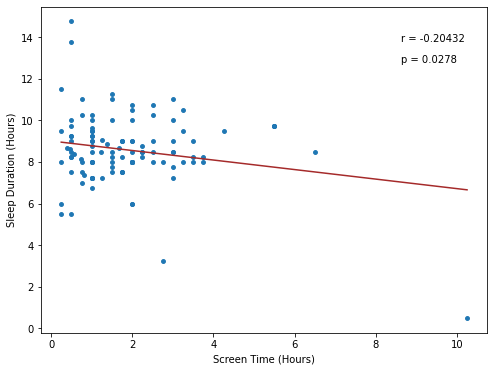

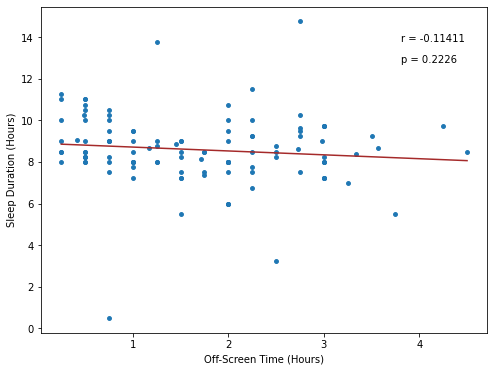

In [13]:
r1, p1 = pearsonr(df4_merged['SleepDuration'], df4_merged['ScreenTime'])
r2, p2 = pearsonr(df4_merged['SleepDuration'], df4_merged['OffScreenTime'])

plt.figure(figsize=(8,6))
plt.scatter(df4_merged['ScreenTime'], df4_merged['SleepDuration'], s=15)
plt.plot(np.unique(df4_merged['ScreenTime']), 
         np.poly1d(np.polyfit(df4_merged['ScreenTime'], df4_merged['SleepDuration'], 1))(np.unique(df4_merged['ScreenTime'])),
        color='brown')


plt.xlabel('Screen Time (Hours)')
plt.ylabel('Sleep Duration (Hours)')
plt.figtext(.75, .8, f'r = {r1.round(5)}')
plt.figtext(.75, .75, f'p = {p1.round(5)}')
plt.show()

plt.figure(figsize=(8,6))
plt.scatter(df4_merged['OffScreenTime'], df4_merged['SleepDuration'], s=15)
plt.plot(np.unique(df4_merged['OffScreenTime']), 
         np.poly1d(np.polyfit(df4_merged['OffScreenTime'], df4_merged['SleepDuration'], 1))(np.unique(df4_merged['OffScreenTime'])),
        color='brown')


plt.xlabel('Off-Screen Time (Hours)')
plt.ylabel('Sleep Duration (Hours)')
plt.figtext(.75, .8, f'r = {r2.round(5)}')
plt.figtext(.75, .75, f'p = {p2.round(5)}')
plt.show()

The results show that there is some weak negative correlation with sleep duration and screen time after 20:00. In comparison to the off-screen time vs sleep duration plot, from the data we can agree that evening screen time has some impact on sleep duration.

## Creating Plots for Infographic
- Reformatting previous plots

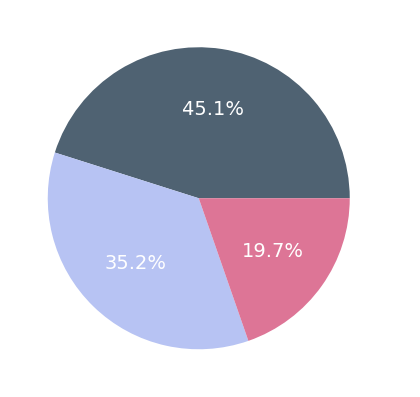

In [14]:
pie_sum = df_pie.groupby('PrimaryActivityCode').DurationMins.sum()
colors = ['#4F6272', '#B7C3F3', '#DD7596']

plt.figure(dpi=100)
pie_sum.plot.pie(label="", 
                 autopct='%1.1f%%', 
                 figsize=(5,5),
                 colors=colors,
                 labels = ['Other', 'Sleep', 'Devices'],
                 textprops={'fontsize': 14, 'color':"w"})
plt.savefig('Pie Chart.png', transparent=True)

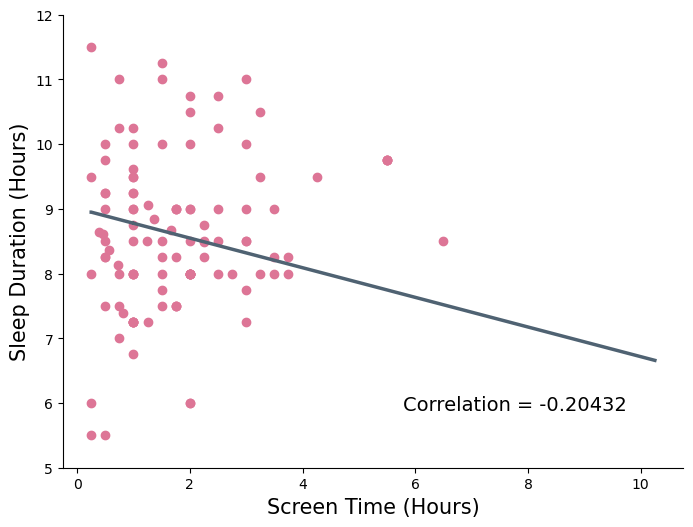

In [15]:
fig, ax = plt.subplots(figsize=(8,6), dpi=100)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.scatter(df4_merged['ScreenTime'], df4_merged['SleepDuration'], color='#DD7596')
plt.plot(np.unique(df4_merged['ScreenTime']), 
        np.poly1d(np.polyfit(df4_merged['ScreenTime'], df4_merged['SleepDuration'], 1))(np.unique(df4_merged['ScreenTime'])),
        color='#4F6272', linewidth=2.5)


plt.xlabel('Screen Time (Hours)', fontsize=15)
plt.ylabel('Sleep Duration (Hours)', fontsize=15)
plt.figtext(.55, .22, f'Correlation = {r1.round(5)}', fontsize=14)
plt.ylim(5,12)
#plt.figtext(.6, .40, f'P-Value = {p1.round(5)}', weight='bold')

fig.savefig('Screen Time Scatterplot.png', transparent=True)

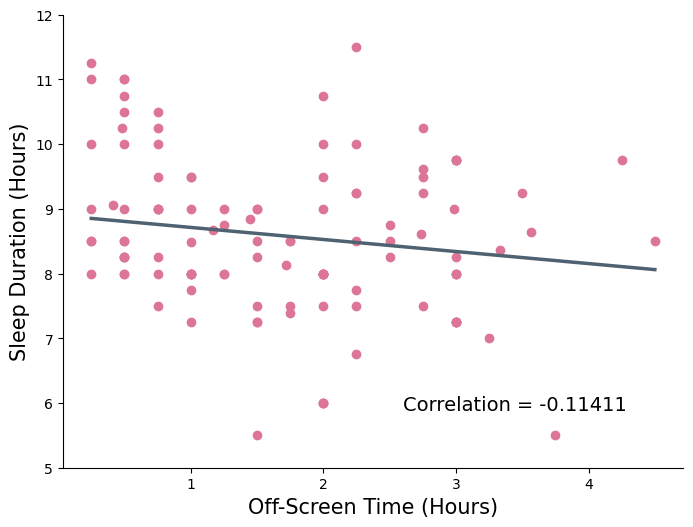

In [16]:
fig, ax = plt.subplots(figsize=(8,6), dpi=100)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.scatter(df4_merged['OffScreenTime'], df4_merged['SleepDuration'], color='#DD7596')
plt.plot(np.unique(df4_merged['OffScreenTime']), 
        np.poly1d(np.polyfit(df4_merged['OffScreenTime'], df4_merged['SleepDuration'], 1))(np.unique(df4_merged['OffScreenTime'])),
        color='#4F6272', linewidth=2.5)


plt.xlabel('Off-Screen Time (Hours)', fontsize=15)
plt.ylabel('Sleep Duration (Hours)', fontsize=15)
plt.figtext(.55, .22, f'Correlation = {r2.round(5)}', fontsize=14)
#plt.figtext(.6, .41, f'P-Value = {p2.round(5)}', weight='bold')
plt.ylim(5,12)
fig.savefig('Off-Screen Time Scatterplot.png', transparent=True)

## Exploring Dataset sourced from Kaggle
- I have compared the daily activities of Data Science students with that of the average american citizen. The data I have used is from the American Time Use Survey, and can be found at: https://www.kaggle.com/datasets/bls/american-time-use-survey?resource=download&select=atusact.csv

In [17]:
activity_us = pd.read_csv('atusact.csv')
activity_us = activity_us[['tuactdur24','trcodep']]
activity_us.loc[:, 'trcodep'] = activity_us['trcodep'].apply(lambda x: '0' + str(x) if len(str(x))==5 else x)
activity_us['trcodep'] = activity_us['trcodep'].apply(lambda x:'Sleeping' if str(x)[0:4] == '0101' else x) 

screen_activities = ['120303', '120304', '120307', '120308']
activity_us['trcodep'] = activity_us['trcodep'].apply(lambda x:'Devices' if str(x) in screen_activities else x) 

activity_us['trcodep'][(activity_us['trcodep'] != 'Sleeping') & (activity_us['trcodep'] != 'Devices')] = 'Other'

/var/folders/mk/6dqc1l9n1hd216kbwtlcskyw0000gn/T/ipykernel_72885/1709770882.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  activity_us['trcodep'][(activity_us['trcodep'] != 'Sleeping') & (activity_us['trcodep'] != 'Devices')] = 'Other'


In [18]:
activity_us = activity_us.rename(columns={'tuactdur24': 'ActivityDuration', 'trcodep': 'Activity'})

In [19]:
activity_us

,ActivityDuration,Activity
0,60,Other
1,30,Other
2,600,Sleeping
3,150,Devices
4,5,Other
...,...,...
3347088,15,Other
3347089,53,Other
3347090,15,Other
3347091,165,Devices


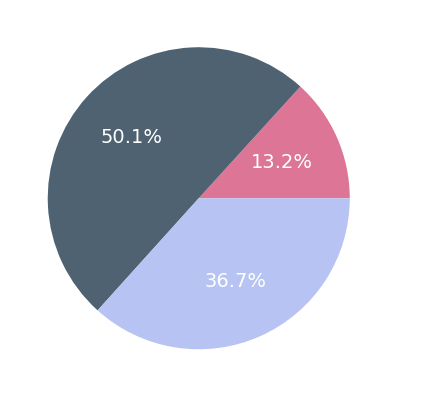

In [20]:
activity_us_sum = activity_us.groupby('Activity').ActivityDuration.sum()
colors = ['#DD7596', '#4F6272', '#B7C3F3']

plt.figure(dpi=100)
activity_us_sum.plot.pie(label="", 
                 autopct='%1.1f%%', 
                 figsize=(5,5),
                 colors=colors,
                 labels = ['Devices', 'Other', 'Sleep'],
                 textprops={'fontsize': 14, 'color':"w"})
plt.savefig('Pie Chart 2.png', transparent=True)